In [1]:
import numpy as np
import numpy.fft as fft
import scipy.ndimage.filters as filters
import scipy.ndimage.measurements as meas
import scipy.misc as misc
import matplotlib.pyplot as plt
from math import ceil as ceil

# Loads images into memory as a 3d array and then finds the median for each pixel along the third axis.
# Expensive memory usage for anything more than a few images; perhaps there's a better way to do it.
def image_median(image_range):
    num_images = image_range.shape[0]
    file_name = 'IMAG%i.JPG' % (image_range[0])
    temp_image = misc.imread(file_name, flatten=True)
    matrix_shape = [temp_image.shape[0], temp_image.shape[1], num_images]
    image_3d = np.zeros(matrix_shape)
    image_3d[:,:,0] = temp_image[:,:]
    
    for i in range(1,num_images):
        file_name = 'IMAG%i.JPG' % (image_range[i])
        image_3d[:,:,i] = misc.imread(file_name, flatten=True)
    
    return np.median(image_3d, axis=2)

# Loads images into memory and sums them to a single 2d array. The normalized array is then returned.
# Less memory intensive than determining the median, as only the space of a single image is required.
def image_mean(image_range):
    num_images = image_range.shape[0]
    file_name = 'IMAG%i.JPG' % (image_range[0])
    image = misc.imread(file_name)
    
    for i in range(1,num_images):
        file_name = 'IMAG%i.JPG' % (image_range[i])
        image += misc.imread(file_name)
    
    return image/float(num_images)

# Implements the flat and dark field corrections to a series of images.
def image_scrubber(image_range, master_dark, master_flat):
    diff_flat_dark = master_flat - master_dark
    num_images = image_range.shape[0]
    file_name = 'IMAG%i.JPG' % (image_range[0])
    temp_image = misc.imread(file_name) #, flatten=True)
    matrix_shape = [temp_image.shape[0], temp_image.shape[1], num_images]
    scrubbed_images = np.zeros(matrix_shape)
    scrubbed_images[:,:,0] = (temp_image[:,:] - master_dark) / diff_flat_dark
    
    for i in range(1,num_images):
        file_name = 'IMAG%i.JPG' % (image_range[i])
        scrubbed_images[:,:,i] = (misc.imread(file_name) \
                                  - master_dark) / diff_flat_dark
    
    return scrubbed_images

# 
def image_scrubber_disk(image_range, master_dark, master_flat):
    diff_flat_dark = master_flat - master_dark
    num_images = image_range.shape[0]
    file_name = 'IMAG%i.JPG' % (image_range[0])
    scrubbed_image = (misc.imread(file_name) - master_dark) / diff_flat_dark
    image_save(image_blue(scrubbed_image), image_range[0])
    
    for i in range(1,num_images):
        file_name = 'IMAG%i.JPG' % (image_range[i])
        scrubbed_image = (misc.imread(file_name) - master_dark) / diff_flat_dark
        image_save(image_blue(scrubbed_image), image_range[i])
    
    return

# 
def image_flatten(image):
    return np.sum(image, axis=2)

#
def image_blue(image):
    return image[:,:,2]

# Resizes images down to the specified size. Ideally this should be looked
# into further for what will give the least error for processing. Note that
# downsampling by a factor larger than 2 causes a lot of issues. The solution
# to this is to repeatedly apply a downsampling by two in a pyramid reduction.
def image_binner(images_3d, output_size, interp='bilinear'):
    if images_3d.ndim == 3:
        num_images = images_3d.shape[2]
    elif images_3d.ndim == 2:
        num_images = 1
    resized_images_3d = np.zeros(output_size[0], output_size[1], num_images)
    for i in range(num_images):
        resized_images_3d[:,:,i] = misc.imresize(images_3d[:,:,i], output_size, interp)
    return resized_images_3d

# Returns the centroid of each image in a stack along the third array dimension.
def centroid(images_3d):
    if images_3d.ndim == 3:
        num_images = images_3d.shape[2]
        centroids = np.zeros([num_images, 2])
        for i in range(num_images):
            centroids[i,:] = meas.center_of_mass(images_3d[:,:,i])
        return centroids
    elif images_3d.ndim == 2:
        return meas.center_of_mass(images_3d)
    else:
        raise ValueError('Only 2d images or a stack along the third dimension thereof are supported.')

# Crops the given images to a square of specified size around the given coordinates.
def center_crop(images_3d, centroids_2d, size):
    if images_3d.ndim == 3:
        num_images = images_3d.shape[2]
        matrix_shape = [size[0], size[1], num_images]
        cropped_images_3d = np.zeros(matrix_shape)
        for i in range(num_images):
            cropped_images_3d[:,:,i] = images_3d[ceil(centroids_2d[i,0]) - size[0]/2 : ceil(centroids_2d[i,0]) + size[0]/2, \
                                                ceil(centroids_2d[i,1]) - size[1]/2 : ceil(centroids_2d[i,1]) + size[1]/2, i]
        if cropped_images_3d.shape != matrix_shape:
            raise ValueError('Crop size overran image boundaries.')
        else:
            return cropped_images_3d
    elif images_3d.ndim == 2:
        return images_3d[ceil(centroids_2d[0]) - size[0]/2 : ceil(centroids_2d[0]) + size[0]/2, \
                              ceil(centroids_2d[1]) - size[1]/2 : ceil(centroids_2d[1]) + size[1]/2]
    else:
        raise ValueError('Only 2D images and 3D stacks thereof are currently supported.')

# Image here should be renamed and ideally the function should be rewritten for a 3d stack of images.
# See: https://gist.github.com/zonca/1348792 & https://gist.github.com/derricw/95eab740e1b08b78c03f
def image_bin(image, size):
    if image.ndim == 2:
        return image.reshape(size[0],image.shape[0]/size[0],size[1],image.shape[1]/size[1]).sum(axis=(1,3))
    else:
        raise ValueError('3d stacks of images not yet supported.')
#     if image.ndim == 3:  
#         return image.reshape

#
# def fourier_crop():
#     return

#
def image_save(images_3d, file_nums=[]):
    if images_3d.ndim == 3:
        num_images = images_3d.shape[2]
        if file_nums == []:
            file_nums = np.arange(num_images)
        for i in range(num_images):
            file_name = 'Processed_Image_%i.txt' % (file_nums[i])
            np.savetxt(file_name, images_3d[:,:,i], delimiter=',')
    elif images_3d.ndim == 2:
        if file_nums == []:
            file_nums = 1
        file_name = 'Processed_Image_%i.txt' % (file_nums)
        np.savetxt(file_name, images_3d, delimiter=',')
    return

#
def image_save_color(images_3d, file_nums=[]):
    if images_3d.shape[2]%3 != 0:
        raise ValueError('Number of colour pages passed is not a multiple of 3.')
    num_images = images_3d.shape[2]/3
    colours = ['R', 'G', 'B']
    if num_images > 1:
        if file_nums == []:
            file_nums = np.arange(num_images)
        for i in range(num_images):
            for j in range(3):
                file_name = 'Processed_Image_%i%c.txt' % (file_nums[i],colours[j])
                np.savetxt(file_name, images_3d[:,:,j], delimiter=',')
    elif num_images == 1:
        if file_nums == []:
            file_nums = 1
        for j in range(3):
            file_name = 'Processed_Image_%i%c.txt' % (file_nums,colours[j])
            np.savetxt(file_name, images_3d[:,:,j], delimiter=',')
    return

# 
def image_load(image_name, image_range):
    num_images = image_range.shape[0]
    file_name = image_name % (image_range[0])
    temp_image = image_blue(misc.imread(file_name))
    matrix_shape = [temp_image.shape[0], temp_image.shape[1], num_images]
    images_3d = np.zeros(matrix_shape)
    images_3d[:,:,0] = temp_image[:,:]
    
    for i in range(1,num_images):
        file_name = 'IMAG%i.JPG' % (image_range[i])
        images_3d[:,:,i] = image_blue(misc.imread(file_name))
    return images_3d

# Zero pads an array to make it square in shape.
def zero_pad(array):
    if array.ndim == 2:
        max_dim = np.amax(array.shape)
        pad = np.array([[(max_dim - array.shape[0])//2,(max_dim - array.shape[0])//2] , \
                        [(max_dim - array.shape[1])//2,(max_dim - array.shape[1])//2]])
        return np.pad(array, pad.astype(int), 'constant')
    elif array.ndim == 3:
        max_dim = np.amax(array[:,:,0].shape)
        out = np.zeros([max_dim,max_dim,array.shape[2]])
        pad = np.array([[(max_dim - array[:,:,0].shape[0])//2,(max_dim - array[:,:,0].shape[0])//2] , \
                        [(max_dim - array[:,:,0].shape[1])//2,(max_dim - array[:,:,0].shape[1])//2]])
        for I in range(array.shape[2]):
            out[:,:,I] = np.pad(array[:,:,I], pad.astype(int), 'constant')
        return out
    else:
        raise ValueError('Only a 2D array or 3D stack thereof is supported.')

# Calculates the noise floor by taking the mean of the n outmost rows and columns.
def calc_avg_noise(image, width):
    if image.ndim == 2:
        return (np.sum(image[:,:width+1] + image[:,-width:]) \
                    + np.sum(image[:width+1,width:-width] + image[-width:,width:-width])) \
                        / (2 * width * (image.shape[0] + image.shape[1] - 2 * width))
    elif image.ndim == 3:
        avg = np.zeros(image.shape[2])
        for I in range(image.shape[2]):
            avg[I] = calc_avg_noise(image[:,:,I])
        return avg
    else:
        raise ValueError('Input dimensionality error. Please pass a 2D or 3D stack of images.')
#     elif image.ndim == 3:
#         return (np.sum(image[:,:width+1,:] + image[:,-width:,:], axis=(0,1)) \
#                     + np.sum(image[:width+1,width:-width,:] + image[-width:,width:-width,:], axis=(0,1))) \
#                         / (2 * width * (image.shape[0] + image.shape[1] - 2 * width))

        
# Returns an unnormalized 2D super-gaussian given a shape, width (in pixels), and order.
def sgauss(outshape, sigma, n):
    temp0 = np.linspace(-outshape[0]/2,outshape[0]/2,outshape[0]) / sigma[0]
    temp1 = np.linspace(-outshape[1]/2,outshape[1]/2,outshape[1]) / sigma[1]
    domain = temp0[:,np.newaxis]**2 + temp1**2
    return np.exp(-domain**(n/2) / 2)

# Sets everything below the threshold value to zero.
def zerothresh(array, threshold):
    return np.where(array < threshold, 0, array)
        
%matplotlib inline

In [23]:
file_name = 'FROG Trace 2.jpg'
image = misc.imread(file_name)
print(calc_avg_noise(image[:,:,0],3))

ValueError: operands could not be broadcast together with shapes (512,4) (512,3) 

In [14]:
## SuperGaussian, Mean Subtraction, and Fourier Filtering on Ground Glass Data


file_name = 'FROG Trace 2.jpg'
image = misc.imread(file_name)
colours = ['R', 'G', 'B']

crop_size = np.array([380,380])
binned_size = np.array([95,95])
output_size = np.array([np.amax(binned_size),np.amax(binned_size)])
filter_sigma = np.array([30,30])
filter_order = 10
filter_threshold = 0.1

print(calc_avg_noise(image[:,:,0], 3))

centroids = centroid(image)
data = np.zeros([*output_size, image.shape[2]])

for I in range(image.shape[2]):
    data[:,:,I] = zero_pad(image_bin(center_crop(image[:,:,I], centroids[I,:], crop_size), binned_size))
sgauss_filters = zerothresh(sgauss(data.shape, filter_sigma, filter_order), filter_threshold)
filtered_data = data * sgauss_filters[:,:,np.newaxis]

for J in range(image.shape[2]):
    image_name = 'Raw_Image %c' % (colours[J])
    fig,ax = plt.subplots(figsize=(10,8))
    plt.imshow(image[:,:,J])
    plt.colorbar()
    ax.set_title(image_name,fontsize=20)
    ax.axvline(centroids[0,0])
    ax.axhline(centroids[0,1])
    
# for J in range(image.shape[2]):
#     file_name = 'FROG_Trace_Filtered 2 %c.txt' % (colours[J])
#     np.savetxt(file_name, data[:,:,J], delimiter=',')
    
for J in range(image.shape[2]):
    image_name = 'Filtered_Image %c' % (colours[J])
    fig,ax = plt.subplots(figsize=(10,8))
    plt.imshow(filtered_data[:,:,J])
    plt.colorbar()
    ax.set_title(image_name,fontsize=20)

ValueError: operands could not be broadcast together with shapes (512,4) (512,3) 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:117: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[ 316.34806086  299.4403038 ]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:125: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


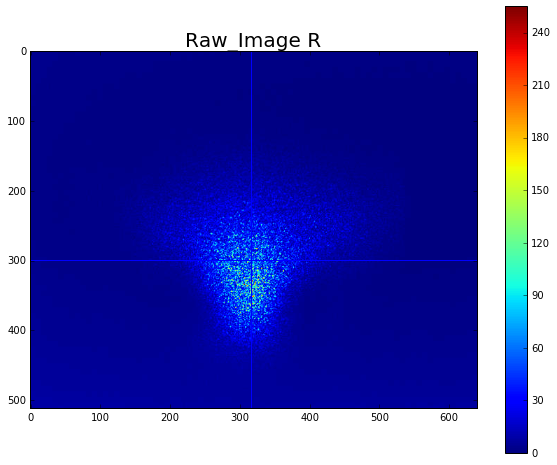

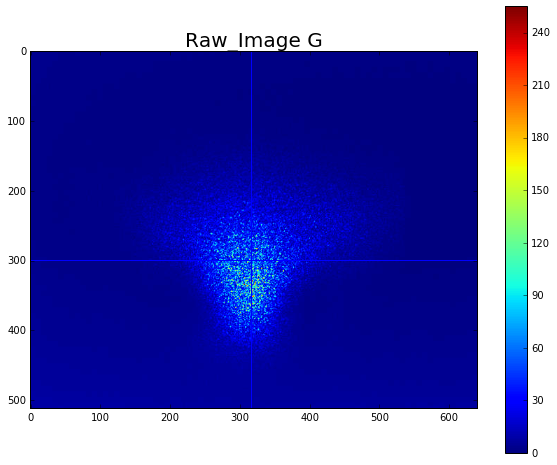

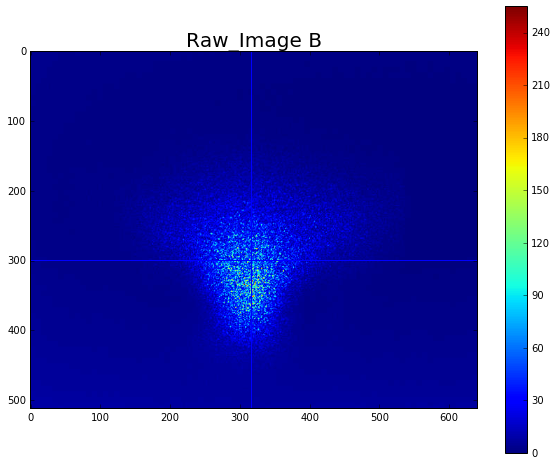

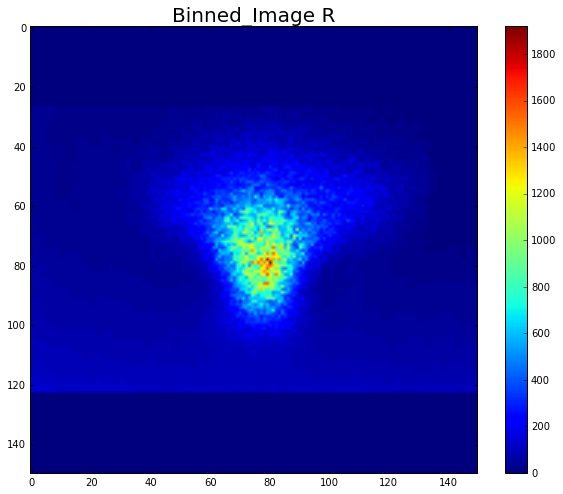

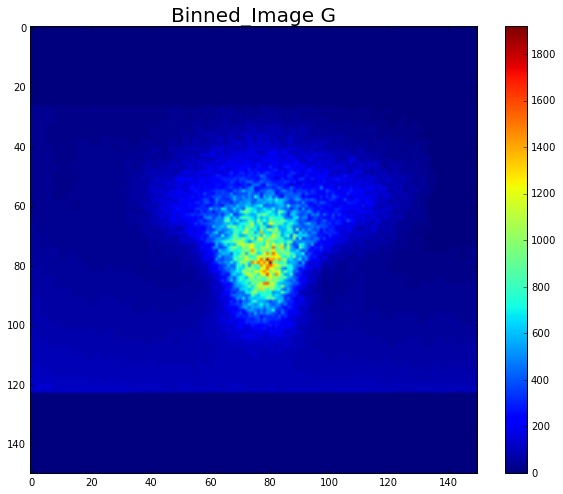

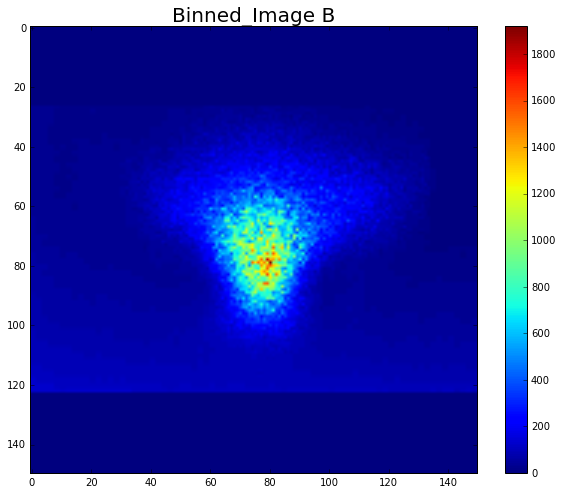

In [10]:
## Ground Glass Data After Micra Reallignment

file_name = 'FROG Trace 2.jpg'
image = misc.imread(file_name)
crop_size = np.array([384,600])
binned_size = np.array([96,150])
output_size = np.array([np.amax(binned_size),np.amax(binned_size)])
colours = ['R', 'G', 'B']

centroids = centroid(image)
temp = center_crop(image[:,:,0], centroids[0,:], crop_size)
print(centroids[0,:])
for J in range(3):
    image_name = 'Raw_Image %c' % (colours[J])
    fig,ax = plt.subplots(figsize=(10,8))
    plt.imshow(image[:,:,J])
    plt.colorbar()
    ax.set_title(image_name,fontsize=20)
    ax.axvline(centroids[0,0])
    ax.axhline(centroids[0,1])
    
Data = np.zeros([*output_size, image.shape[2]])
for I in range(image.shape[2]):
    Data[:,:,I] = zero_pad(image_bin(center_crop(image[:,:,I], centroids[I,:], crop_size), binned_size))

for J in range(3):
    file_name = 'FROG_Trace 2 %c.txt' % (colours[J])
    np.savetxt(file_name, Data[:,:,J], delimiter=',')
    
for J in range(image.shape[2]):
    image_name = 'Binned_Image %c' % (colours[J])
    fig,ax = plt.subplots(figsize=(10,8))
    plt.imshow(Data[:,:,J])
    plt.colorbar()
    ax.set_title(image_name,fontsize=20)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:117: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[ 317.35140782  298.72124856]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:125: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


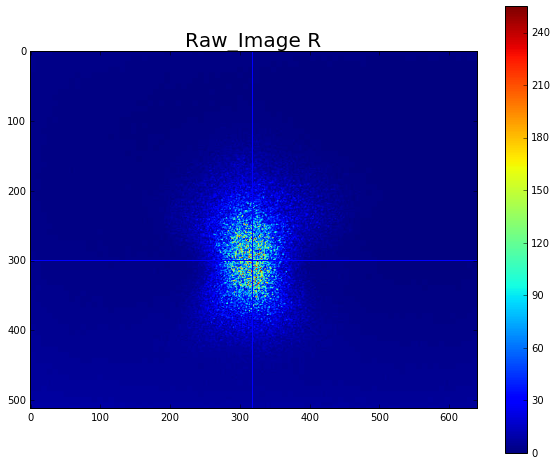

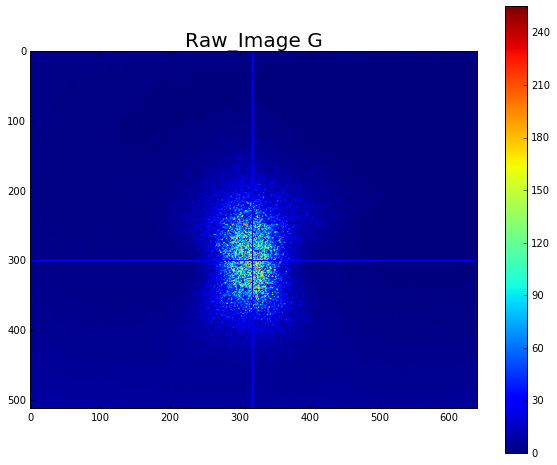

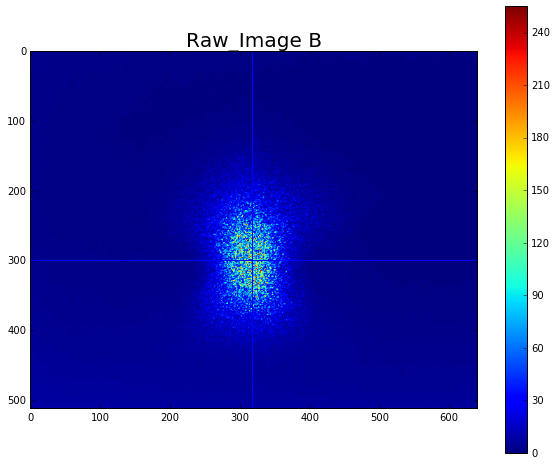

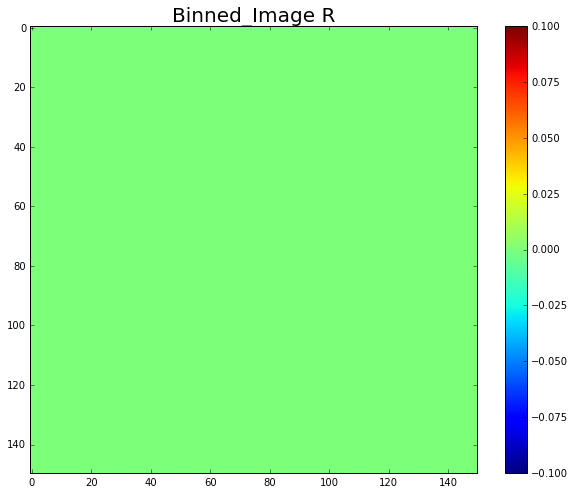

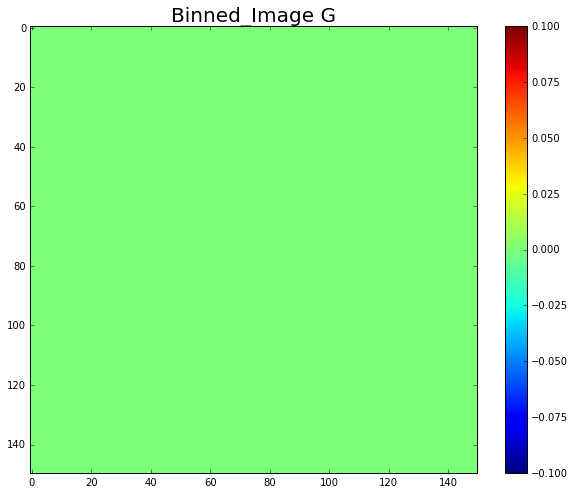

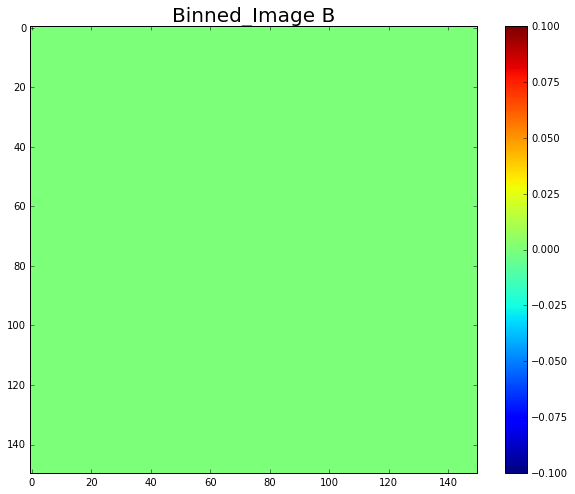

In [11]:
## Ground Glass Data After Micra Reallignment

file_name = 'FROG Trace 3.jpg'
image = misc.imread(file_name)
crop_size = np.array([384,600])
binned_size = np.array([96,150])
output_size = np.array([np.amax(binned_size),np.amax(binned_size)])
colours = ['R', 'G', 'B']

centroids = centroid(image)
temp = center_crop(image[:,:,0], centroids[0,:], crop_size)
print(centroids[0,:])
for J in range(3):
    image_name = 'Raw_Image %c' % (colours[J])
    fig,ax = plt.subplots(figsize=(10,8))
    plt.imshow(image[:,:,J])
    plt.colorbar()
    ax.set_title(image_name,fontsize=20)
    ax.axvline(centroids[0,0])
    ax.axhline(centroids[0,1])
    
Data = np.zeros([*output_size, image.shape[2]])

temp1 = np.zeros([*crop_size, image.shape[2]])
temp2 = np.zeros([*binned_size, image.shape[2]])
for I in range(image.shape[2]):
    temp1[:,:,I] = center_crop(image[:,:,I], centroids[I,:], crop_size)
    temp2[:,:,I] = image_bin(temp1[:,:,I], binned_size)
temp3 = zero_pad(temp2)

# for I in range(image.shape[2]):
#     Data[:,:,I] = zero_pad(image_bin(center_crop(image[:,:,I], centroids[I,:], crop_size), binned_size))

for J in range(3):
    file_name = 'FROG_Trace 3 %c.txt' % (colours[J])
    np.savetxt(file_name, Data[:,:,J], delimiter=',')
    
for J in range(image.shape[2]):
    image_name = 'Binned_Image %c' % (colours[J])
    fig,ax = plt.subplots(figsize=(10,8))
    plt.imshow(Data[:,:,J])
    plt.colorbar()
    ax.set_title(image_name,fontsize=20)